# Using information theory to evaluate features

The mutual information (MI) between a feature and the outcome is a measure of the mutual dependence between the two variables. It extends the notion of correlation to nonlinear relationships. More specifically, it quantifies the information obtained about one random variable through the other random variable.

The concept of MI is closely related to the fundamental notion of entropy of a random variable. Entropy quantifies the amount of information contained in a random variable. Formally, the mutual information—I(X, Y)—of two random variables, X and Y, is defined as the following:

The sklearn function implements feature_selection.mutual_info_regression that computes the mutual information between all features and a continuous outcome to select the features that are most likely to contain predictive information. There is also a classification version (see the documentation for more details). 

This notebook contains an application to the financial data we created in Chapter 4, Alpha Factor Research.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

We use the data produced in [Chapter 4](../../04_alpha_factor_research/00_data/feature_engineering.ipynb).


In [4]:
with pd.HDFStore('../data/assets.h5') as store:
    data = store['engineered_features']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      358914 non-null  float64
 1   return_2m      358914 non-null  float64
 2   return_3m      358914 non-null  float64
 3   return_6m      358914 non-null  float64
 4   return_9m      358914 non-null  float64
 5   return_12m     358914 non-null  float64
 6   Mkt-RF         314802 non-null  float64
 7   SMB            314802 non-null  float64
 8   HML            314802 non-null  float64
 9   RMW            314802 non-null  float64
 10  CMA            314802 non-null  float64
 11  target_1m      358914 non-null  float64
 12  target_2m      357076 non-null  float64
 13  target_3m      355238 non-null  float64
 14  target_6m      349724 non-null  float64
 15  target_12m     338696 non-null  float64
 16  

## Create Dummy variables

In [6]:
# data contains no columns 'year', 'month'
# dummy_data = pd.get_dummies(data,
#                             columns=['year','month', 'msize', 'age',  'sector'],
#                             prefix=['year','month', 'msize', 'age', ''],
#                             prefix_sep=['_', '_', '_', '_', ''])
dummy_data = pd.get_dummies(data,
                            columns=['msize', 'age',  'sector'],
                            prefix=['msize', 'age', ''],
                            prefix_sep=['_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 52 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              358914 non-null  float64
 1   return_2m              358914 non-null  float64
 2   return_3m              358914 non-null  float64
 3   return_6m              358914 non-null  float64
 4   return_9m              358914 non-null  float64
 5   return_12m             358914 non-null  float64
 6   Mkt-RF                 314802 non-null  float64
 7   SMB                    314802 non-null  float64
 8   HML                    314802 non-null  float64
 9   RMW                    314802 non-null  float64
 10  CMA                    314802 non-null  float64
 11  target_1m              358914 non-null  float64
 12  target_2m              357076 non-null  float64
 13  target_3m      

## Mutual Information

### Original Data

In [7]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [8]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [9]:
mutual_info.sum()

target_1m     0.013376
target_2m     0.015894
target_3m     0.021504
target_6m     0.037217
target_12m    0.049999
dtype: float64

In [11]:
mutual_info

,target_1m,target_2m,target_3m,target_6m,target_12m
return_1m,0.000744,0.001776,0.000706,0.002718,0.003148
return_2m,0.001155,0.001541,0.002292,0.000955,0.003628
return_3m,0.000000,0.000086,0.000990,0.000412,0.002463
return_6m,0.001345,0.000000,0.000113,0.000928,0.003308
return_9m,0.000000,0.000529,0.000000,0.003581,0.001855
return_12m,0.000000,0.000833,0.002430,0.001290,0.002108
Mkt-RF,0.000222,0.000000,0.001031,0.000865,0.001333
SMB,0.001937,0.002380,0.000983,0.001424,0.002234
HML,0.001208,0.001810,0.000765,0.002665,0.003585
RMW,0.000000,0.000937,0.001144,0.004478,0.005241


### Normalized MI Heatmap

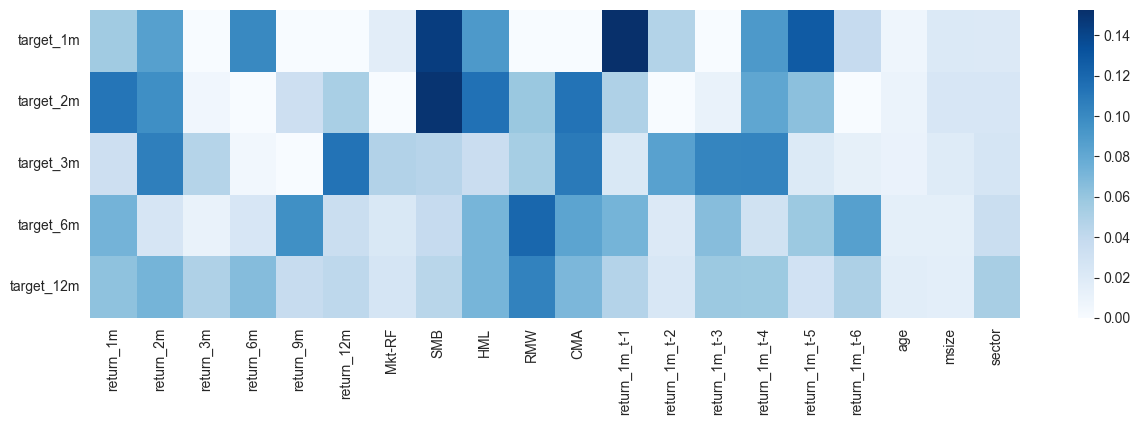

In [12]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

### Dummy Data

In [13]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [14]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [15]:
mutual_info_dummies.sum()

target_1m     0.013457
target_2m     0.016015
target_3m     0.021685
target_6m     0.037639
target_12m    0.050735
dtype: float64

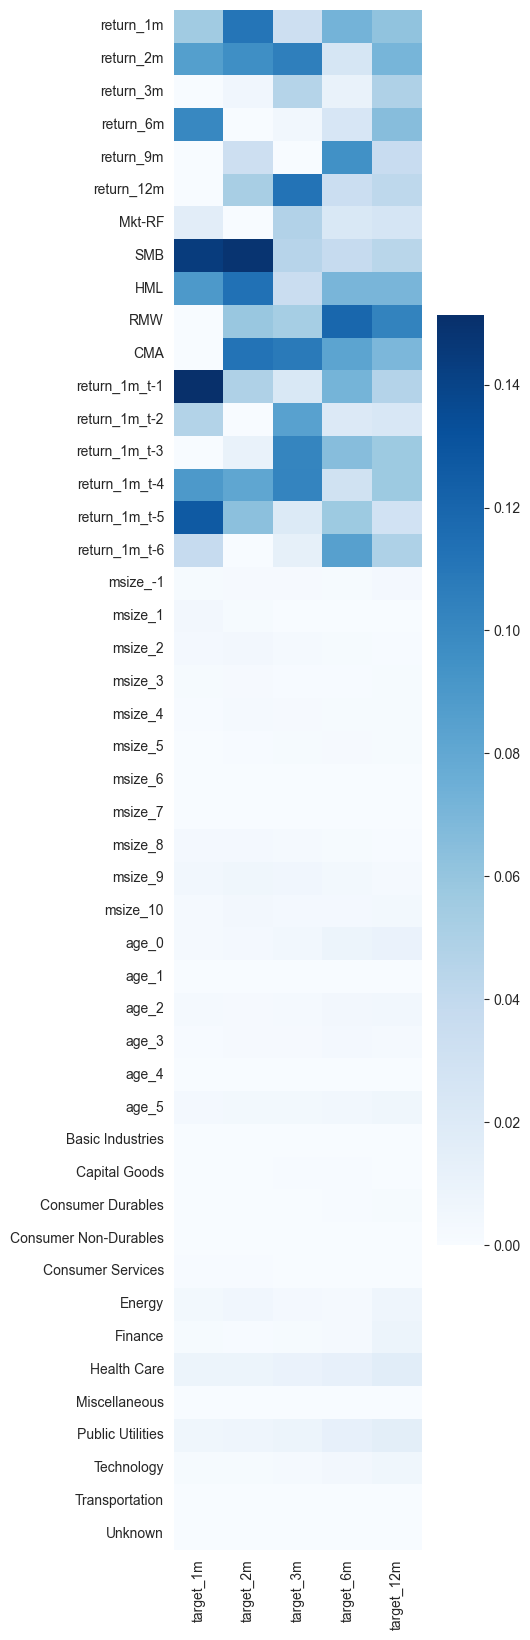

In [16]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');